Found 812 images belonging to 2 classes.
Found 202 images belonging to 2 classes.


C:\Users\Shreyash\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.7298 - loss: 0.5075 - val_accuracy: 0.9604 - val_loss: 0.1189
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9563 - loss: 0.1105 - val_accuracy: 0.9653 - val_loss: 0.0925
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9919 - loss: 0.0340 - val_accuracy: 0.9307 - val_loss: 0.1311
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9883 - loss: 0.0400 - val_accuracy: 0.9604 - val_loss: 0.0892
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9923 - loss: 0.0281 - val_accuracy: 0.9802 - val_loss: 0.0484
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9871 - loss: 0.0351 - val_accuracy: 0.9950 - val_loss: 0.0358
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9963 - loss: 0.0136 - val_accuracy: 0.9851 - val_loss: 0.0369
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9912 - loss: 0.0281 - val_accuracy: 0.9752 - val_loss:


Final validation accuracy: 95.05%


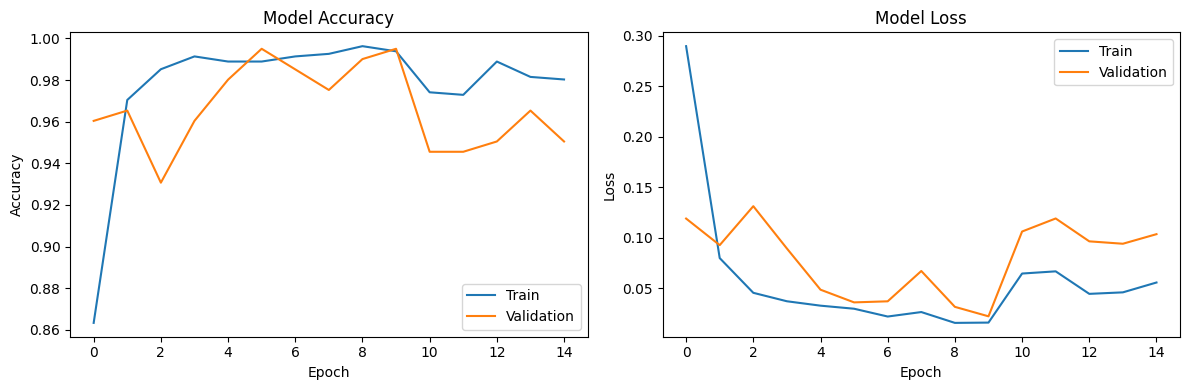

In [9]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import os

# Set random seed for reproducibility
tf.random.set_seed(42)

# Define parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
DATA_DIR = "D:/infra_e_net"  # Updated path

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create training and validation generators
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# Load base model without top layers
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

# Fine-tune base model
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Compile again with low learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Continue training
history_fine = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)

# Save model
model.save("infrastructure_model_binary.h5")

# Print final accuracy
final_accuracy = history_fine.history['val_accuracy'][-1] * 100
print(f"\nFinal validation accuracy: {final_accuracy:.2f}%")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'])
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 905ms/step


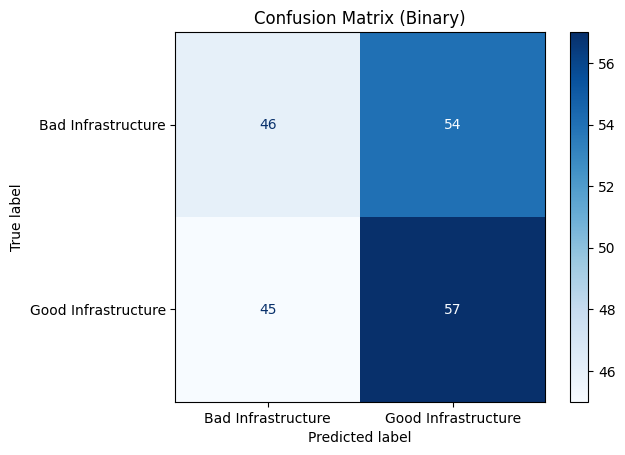


Classification Report:
                     precision    recall  f1-score   support

 Bad Infrastructure       0.51      0.46      0.48       100
Good Infrastructure       0.51      0.56      0.54       102

           accuracy                           0.51       202
          macro avg       0.51      0.51      0.51       202
       weighted avg       0.51      0.51      0.51       202



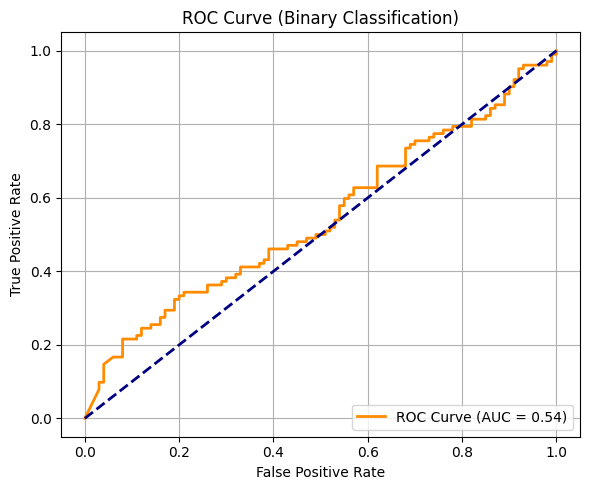

In [11]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on validation data
val_steps = validation_generator.samples // validation_generator.batch_size + 1
y_true = validation_generator.classes
y_pred_prob = model.predict(validation_generator, steps=val_steps)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)  # Convert to binary

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Bad Infrastructure", "Good Infrastructure"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Binary)")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Bad Infrastructure", "Good Infrastructure"]))

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Binary Classification)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


Found 278 images belonging to 2 classes.


C:\Users\Shreyash\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


278/278 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step


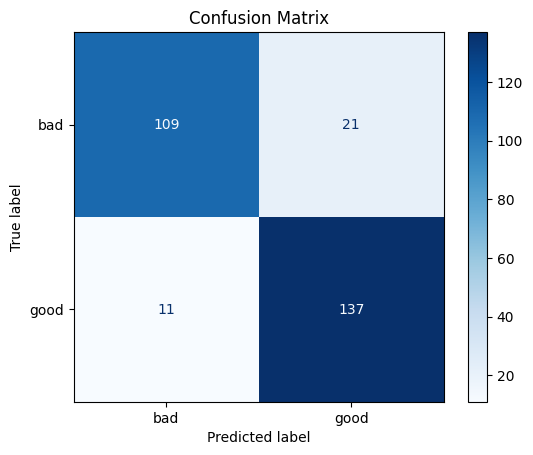

Classification Report:

              precision    recall  f1-score   support

         bad       0.91      0.84      0.87       130
        good       0.87      0.93      0.90       148

    accuracy                           0.88       278
   macro avg       0.89      0.88      0.88       278
weighted avg       0.89      0.88      0.88       278



In [18]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# === CONFIGURATION ===
IMG_SIZE = 224
BATCH_SIZE = 1  # For small test set
TEST_DIR = "D:/test_infra/test"
MODEL_PATH = "infrastructure_model_binary.h5"  # Your trained model

# === LOAD MODEL ===
model = tf.keras.models.load_model(MODEL_PATH)

# === LOAD TEST DATA ===
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Important to align predictions with filenames
)

# === PREDICT ===
y_probs = model.predict(test_generator)
y_pred = (y_probs > 0.5).astype(int).reshape(-1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())  # ['Bad', 'Good']

# === CONFUSION MATRIX ===
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# === CLASSIFICATION REPORT ===
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


Found 278 images belonging to 2 classes.


C:\Users\Shreyash\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


278/278 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step


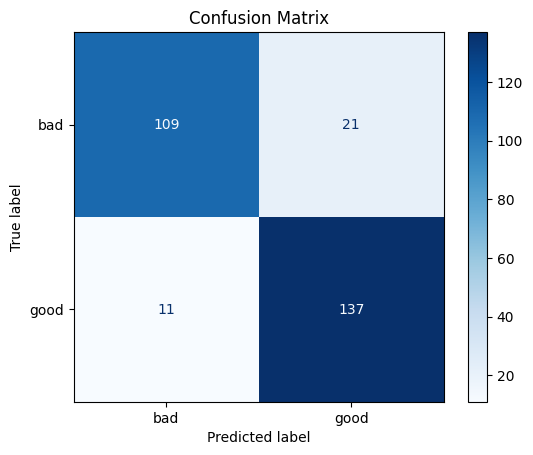


Classification Report:
              precision    recall  f1-score   support

         bad       0.91      0.84      0.87       130
        good       0.87      0.93      0.90       148

    accuracy                           0.88       278
   macro avg       0.89      0.88      0.88       278
weighted avg       0.89      0.88      0.88       278



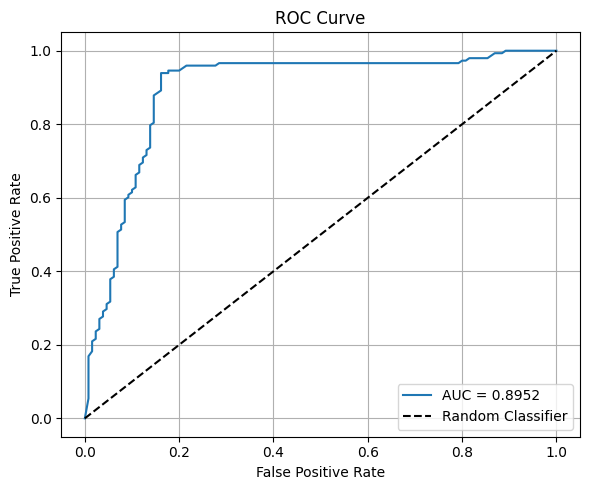

AUC Score: 0.8952


In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve
)

# === CONFIGURATION ===
IMG_SIZE = 224
BATCH_SIZE = 1
TEST_DIR = "D:/test_infra/test"
MODEL_PATH = "infrastructure_model_binary.h5"  # path to your saved model

# === LOAD MODEL ===
model = tf.keras.models.load_model(MODEL_PATH)

# === LOAD TEST DATA ===
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# === PREDICTIONS ===
y_probs = model.predict(test_generator)               # predicted probabilities
y_pred = (y_probs > 0.5).astype(int).reshape(-1)      # binary predictions
y_true = test_generator.classes                       # ground truth
class_names = list(test_generator.class_indices.keys())

# === CONFUSION MATRIX ===
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# === CLASSIFICATION REPORT ===
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# === ROC & AUC ===
auc_score = roc_auc_score(y_true, y_probs)
fpr, tpr, thresholds = roc_curve(y_true, y_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"AUC Score: {auc_score:.4f}")
